In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import os

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

In [2]:
data = pd.read_csv('games.csv')
data['spread'] = data['PTS_home'] - data['PTS_away']
data.head()

,Year,Start (ET),Visitor/Neutral,PTS_away,Home/Neutral,PTS_home,Unnamed: 6,Unnamed: 7,Attend.,Arena,playoff,spread
0,2022,7:30p,Philadelphia 76ers,117,Boston Celtics,126,Box Score,NaN,19156.0,TD Garden,0,9
1,2022,10:00p,Los Angeles Lakers,109,Golden State Warriors,123,Box Score,NaN,18064.0,Chase Center,0,14
2,2022,7:00p,Orlando Magic,109,Detroit Pistons,113,Box Score,NaN,20190.0,Little Caesars Arena,0,4
3,2022,7:00p,Washington Wizards,114,Indiana Pacers,107,Box Score,NaN,15027.0,Gainbridge Fieldhouse,0,-7
4,2022,7:30p,Houston Rockets,107,Atlanta Hawks,117,Box Score,NaN,17878.0,State Farm Arena,0,10


In [3]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(data["Home/Neutral"], sort=True)
away_idx, _ = pd.factorize(data["Visitor/Neutral"], sort=True)
year_idx, year_unique = pd.factorize(data["Year"], sort=True)
was_playoff = data['playoff']
coords = {"team": teams, "year":year_unique}

In [7]:
with pm.Model(coords=coords) as home_model:
    # mutable data
    home_team = pm.MutableData("home_team", home_idx)
    away_team = pm.MutableData("away_team", away_idx)
    year = pm.MutableData("year", year_idx)
    playoff = pm.MutableData('playoff', was_playoff)

    # global model parameters
    sd_home = pm.HalfNormal("sd_home", sigma=2)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_spread = pm.HalfNormal("sd_spread", sigma=3)
    playoff_home = pm.Normal('playoff_home', mu = 0, sigma = 2)

    # team-specific model parameters
    home = pm.Normal("home", mu=3, sigma=sd_home, dims="team")
    home_year = pm.Normal("home_year", mu=0, sigma=1, dims=["team","year"])
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims=["team","year"])

    # per year adjustment

    spread = (atts_star[home_team, year] - atts_star[away_team, year] + 
              home[home_team] + home_year[home_team, year] + playoff*playoff_home)


    # likelihood of observed data
    y = pm.Normal(
        "y",
        mu=spread,
        sigma = sd_spread,
        observed=data["spread"],
    )
    trace_playoff = pm.sample(1000, tune=1500, cores=4, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_home, sd_att, sd_spread, playoff_home, home, home_year, atts_star]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 43 seconds.


array([[<Axes: title={'center': 'playoff_home'}>,
        <Axes: title={'center': 'playoff_home'}>],
       [<Axes: title={'center': 'home'}>,
        <Axes: title={'center': 'home'}>],
       [<Axes: title={'center': 'home_year'}>,
        <Axes: title={'center': 'home_year'}>],
       [<Axes: title={'center': 'atts_star'}>,
        <Axes: title={'center': 'atts_star'}>],
       [<Axes: title={'center': 'sd_home'}>,
        <Axes: title={'center': 'sd_home'}>],
       [<Axes: title={'center': 'sd_att'}>,
        <Axes: title={'center': 'sd_att'}>],
       [<Axes: title={'center': 'sd_spread'}>,
        <Axes: title={'center': 'sd_spread'}>]], dtype=object)

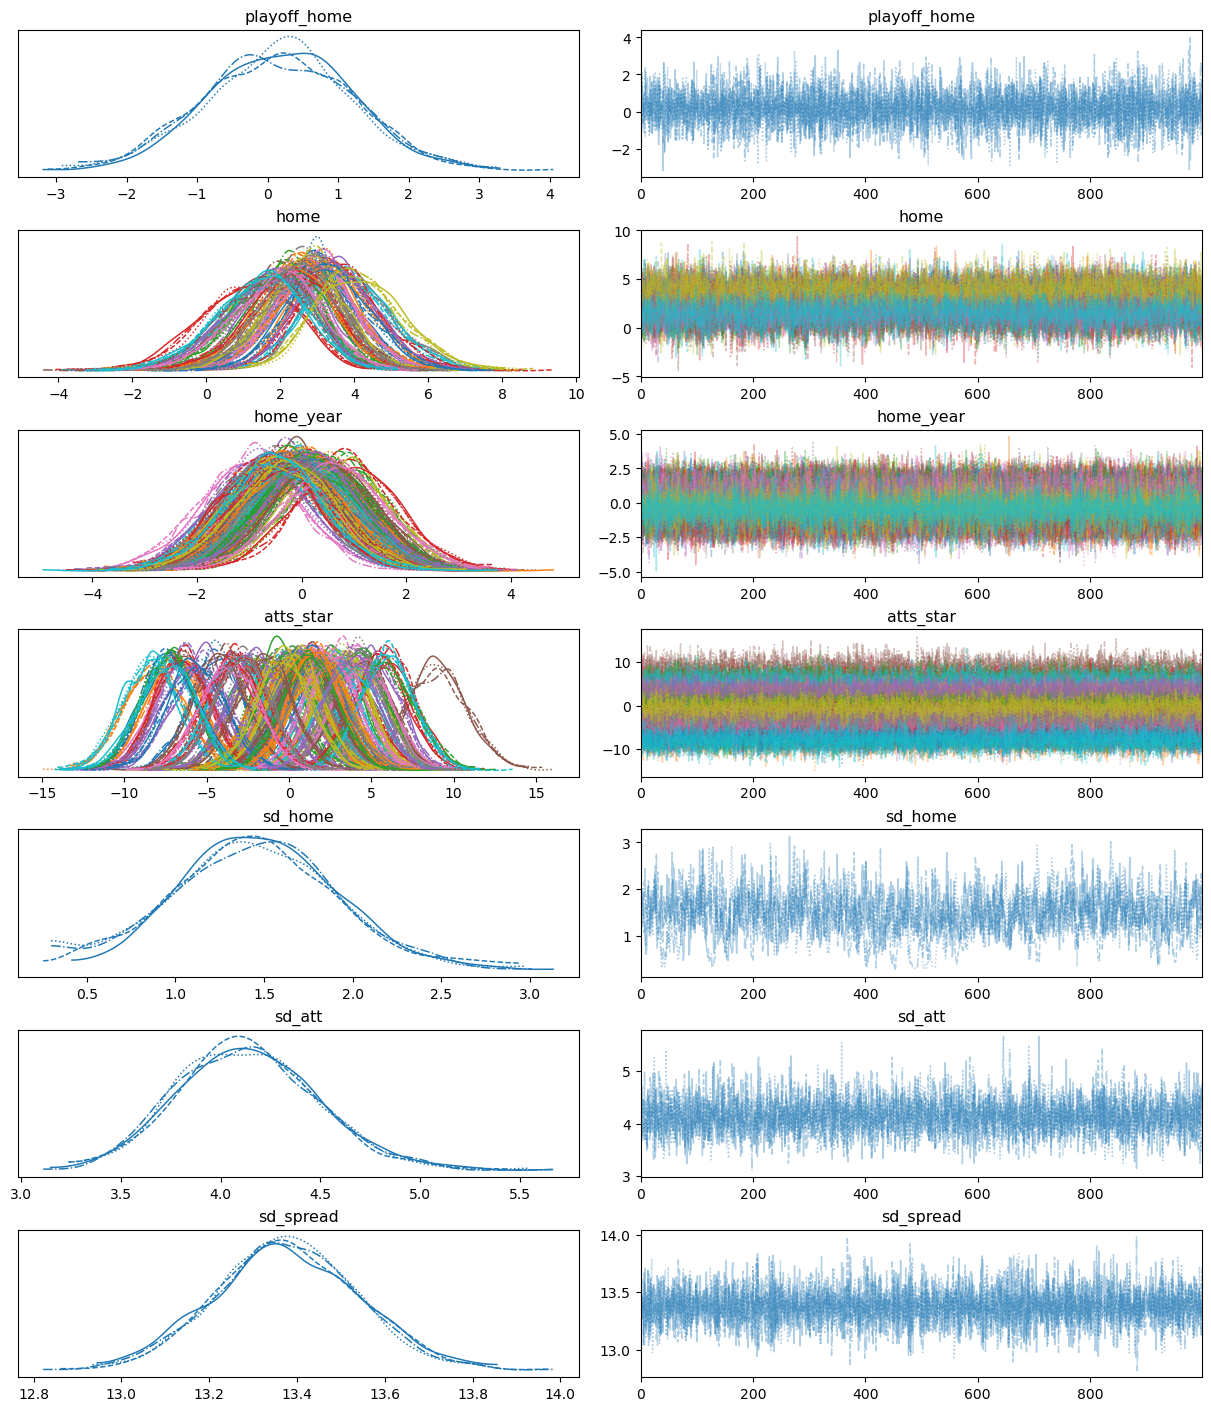

In [8]:
az.plot_trace(trace_playoff)

In [9]:
az.summary(trace_playoff).to_csv('home_court_with_playoffs.csv')

Sampling: [y]


/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<Axes: xlabel='y / y'>

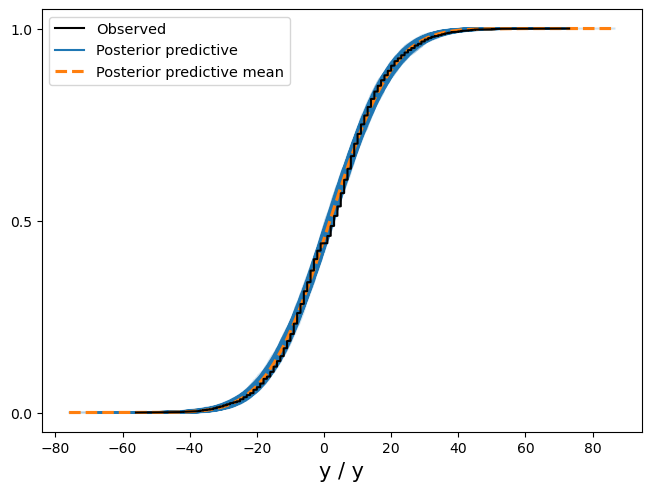

In [61]:
with home_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
az.plot_ppc(trace, kind='cumulative')

In [66]:
df_comp_loo = az.compare({"with_playoff": trace_playoff, "noplayoff": trace_noplayoff})
df_comp_loo

/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_playoff,0,-14468.942119,99.127315,0.000000,0.680522,46.908286,0.000000,False,log
noplayoff,1,-14469.011285,99.290895,0.069166,0.319478,46.926477,0.621593,False,log


In [11]:
df = az.summary(trace_playoff)
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
playoff_home,0.160,1.038,-1.757,2.111,0.011,0.018,8840.0,3130.0,1.0
home[Atlanta Hawks],2.962,1.101,0.977,5.190,0.014,0.011,6119.0,2865.0,1.0
home[Boston Celtics],3.389,1.080,1.466,5.498,0.015,0.012,5234.0,3229.0,1.0
home[Brooklyn Nets],1.880,1.181,-0.380,4.026,0.022,0.015,2942.0,3267.0,1.0
home[Charlotte Hornets],1.142,1.280,-1.159,3.472,0.031,0.022,1694.0,2983.0,1.0
...,...,...,...,...,...,...,...,...,...
"atts_star[Washington Wizards, 2022]",-0.365,1.675,-3.405,2.824,0.027,0.026,3985.0,2387.0,1.0
"atts_star[Washington Wizards, 2023]",-7.398,1.753,-10.844,-4.313,0.028,0.020,4075.0,2946.0,1.0
sd_home,1.448,0.467,0.531,2.346,0.020,0.014,558.0,486.0,1.0
sd_att,4.135,0.351,3.475,4.781,0.005,0.003,5202.0,3531.0,1.0


In [16]:
out_df = pd.DataFrame(columns=['Team', 'Year','Home', 'Year Adjustemnt', 'Yearly Home'])

for year in year_unique:
    for team in teams:
        home = df.at[f'home[{team}]','mean']
        year_adj = df.at[f'home_year[{team}, {year}]','mean']
        year_home = home + year_adj
        out_df.loc[len(out_df)] = [team, year, home, year_adj, year_home]

out_df.to_csv('team_final_results.csv')

        